In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-ct-segmentation/train.csv
/kaggle/input/chest-ct-segmentation/images/images/ID00305637202281772703145_3.jpg
/kaggle/input/chest-ct-segmentation/images/images/ID00060637202187965290703_248.jpg
/kaggle/input/chest-ct-segmentation/images/images/ID00381637202299644114027_36.jpg
/kaggle/input/chest-ct-segmentation/images/images/ID00035637202182204917484_358.jpg
/kaggle/input/chest-ct-segmentation/images/images/ID00082637202201836229724_98.jpg
/kaggle/input/chest-ct-segmentation/images/images/ID00400637202305055099402_261.jpg
/kaggle/input/chest-ct-segmentation/images/images/ID00051637202185848464638_19.jpg
/kaggle/input/chest-ct-segmentation/images/images/ID00009637202177434476278_361.jpg
/kaggle/input/chest-ct-segmentation/images/images/ID00027637202179689871102_127.jpg
/kaggle/input/chest-ct-segmentation/images/images/ID00381637202299644114027_234.jpg
/kaggle/input/chest-ct-segmentation/images/images/ID00104637202208063407045_317.jpg
/kaggle/input/chest-ct-segmentation

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
from glob import glob
from sklearn.utils import shuffle

In [3]:
H = 256
W = 256

In [4]:
def load_data(path,test_size=0.2):
    df = pd.read_csv(path+'train.csv')
    images=df['ImageId'].values
    masks=df['MaskId'].values
    
    images =  [os.path.join(path, f"images/images/{name}") for name in images]
    masks  =  [os.path.join(path, f"masks/masks/{name}") for name in masks]
    
    train_x, valid_x = train_test_split(images, test_size=test_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=test_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [5]:
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

In [6]:
def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x - 1
    x = x.astype(np.int32)
    return x

In [7]:
def tf_parse(x, y):
    def _parse(x, y):
        x = x.decode()
        y = y.decode()
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.int32])
    y = tf.one_hot(y, 3, dtype=tf.int32)
    x.set_shape([H, W, 3])
    y.set_shape([H, W,3])
    return x, y

In [8]:
def tf_dataset(X, Y, batch):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

In [9]:
shape = (256, 256, 3)
num_classes = 3
lr = 1e-4
batch_size = 8
epochs = 10

In [10]:
path = "../input/chest-ct-segmentation/"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
print(f"Dataset: Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

Dataset: Train: 10692 - Valid: 3342 - Test: 2674


In [11]:
train_dataset = tf_dataset(train_x, train_y, batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size)

train_steps = len(train_x)//batch_size
valid_steps = len(valid_x)//batch_size


In [12]:
for x, y in train_dataset:
    print(x.shape, y.shape)
  

(8, 256, 256, 3) (8, 256, 256, 3)
(8, 256, 256, 3) (8, 256, 256, 3)
(8, 256, 256, 3) (8, 256, 256, 3)
(8, 256, 256, 3) (8, 256, 256, 3)
(8, 256, 256, 3) (8, 256, 256, 3)
(8, 256, 256, 3) (8, 256, 256, 3)
(8, 256, 256, 3) (8, 256, 256, 3)
(8, 256, 256, 3) (8, 256, 256, 3)
(8, 256, 256, 3) (8, 256, 256, 3)


KeyboardInterrupt: 

In [13]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [14]:
def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

In [15]:
def build_unet(shape, num_classes):
    inputs = Input(shape)

    """ Encoder """
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 64, pool=True)
    x4, p4 = conv_block(p3, 128, pool=True)

    """ Bridge """
    b1 = conv_block(p4, 256, pool=False)

    """ Decoder """
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1,128, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 64, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    """ Output layer """
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)

    return Model(inputs, output)

In [20]:
model = build_unet((256, 256, 3), 3)
metrics = [dice_coef, iou]
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr), metrics=metrics)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 256, 256, 16) 64          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 256, 256, 16) 0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

In [21]:
callbacks = [
        ModelCheckpoint("model.h5", verbose=1, save_best_model=True),
        ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
        EarlyStopping(monitor="val_loss", patience=5, verbose=1)
    ]

In [22]:
model.fit(train_dataset,steps_per_epoch=train_steps,validation_data=valid_dataset,validation_steps=valid_steps,epochs=epochs,callbacks=callbacks)

Epoch 1/10
1336/1336 [==============================] - 327s 240ms/step - loss: 0.0077 - dice_coef: 0.0090 - iou: 0.0045 - val_loss: 0.0070 - val_dice_coef: 0.0095 - val_iou: 0.0048

Epoch 00001: saving model to model.h5
Epoch 2/10
1336/1336 [==============================] - 122s 91ms/step - loss: 0.0070 - dice_coef: 0.0099 - iou: 0.0050 - val_loss: 0.0063 - val_dice_coef: 0.0106 - val_iou: 0.0053

Epoch 00002: saving model to model.h5
Epoch 3/10
1336/1336 [==============================] - 121s 90ms/step - loss: 0.0066 - dice_coef: 0.0106 - iou: 0.0054 - val_loss: 0.0068 - val_dice_coef: 0.0102 - val_iou: 0.0051

Epoch 00003: saving model to model.h5
Epoch 4/10
1336/1336 [==============================] - 121s 90ms/step - loss: 0.0068 - dice_coef: 0.0106 - iou: 0.0053 - val_loss: 0.0063 - val_dice_coef: 0.0105 - val_iou: 0.0053

Epoch 00004: saving model to model.h5
Epoch 5/10
1336/1336 [==============================] - 122s 91ms/step - loss: 0.0062 - dice_coef: 0.0107 - iou: 0.0054

In [ ]:
model = tf.keras.models.load_model("model.h5")

In [23]:
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from tensorflow.keras import backend as K

In [17]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)


In [18]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [19]:
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [24]:
from keras.metrics import MeanIoU
n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)

In [30]:
path='./'
import shutil
shutil.os.mkdir(path + "result")

In [32]:
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        name = x.split("/")[-1]

        ## Read image
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        x = cv2.resize(x, (W, H))
        x = x / 255.0
        x = x.astype(np.float32)

        ## Read mask
        y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        y = cv2.resize(y, (W, H))   ## (256, 256)
        y = y - 1
        y = np.expand_dims(y, axis=-1) ## (256, 256, 1)
        y = y * (255/num_classes)
        y = y.astype(np.int32)
        y = np.concatenate([y, y, y], axis=2)

        ## Prediction
        p = model.predict(np.expand_dims(x, axis=0))[0]
        p = np.argmax(p, axis=-1)
        p = np.expand_dims(p, axis=-1)
        p = p * (255/num_classes)
        p = p.astype(np.int32)
        p = np.concatenate([p, p, p], axis=2)

        x = x * 255.0
        x = x.astype(np.int32)

        h, w, _ = x.shape
        line = np.ones((h, 10, 3)) * 255

        # print(x.shape, line.shape, y.shape, line.shape, p.shape)

        final_image = np.concatenate([x, line, y, line, p], axis=1)
        cv2.imwrite(f"./result/{name}", final_image)

100%|██████████| 2674/2674 [02:19<00:00, 19.14it/s]


In [34]:
from glob import glob
import os
path='./'
test_images=glob(os.path.join(path,"result","*.jpg"))

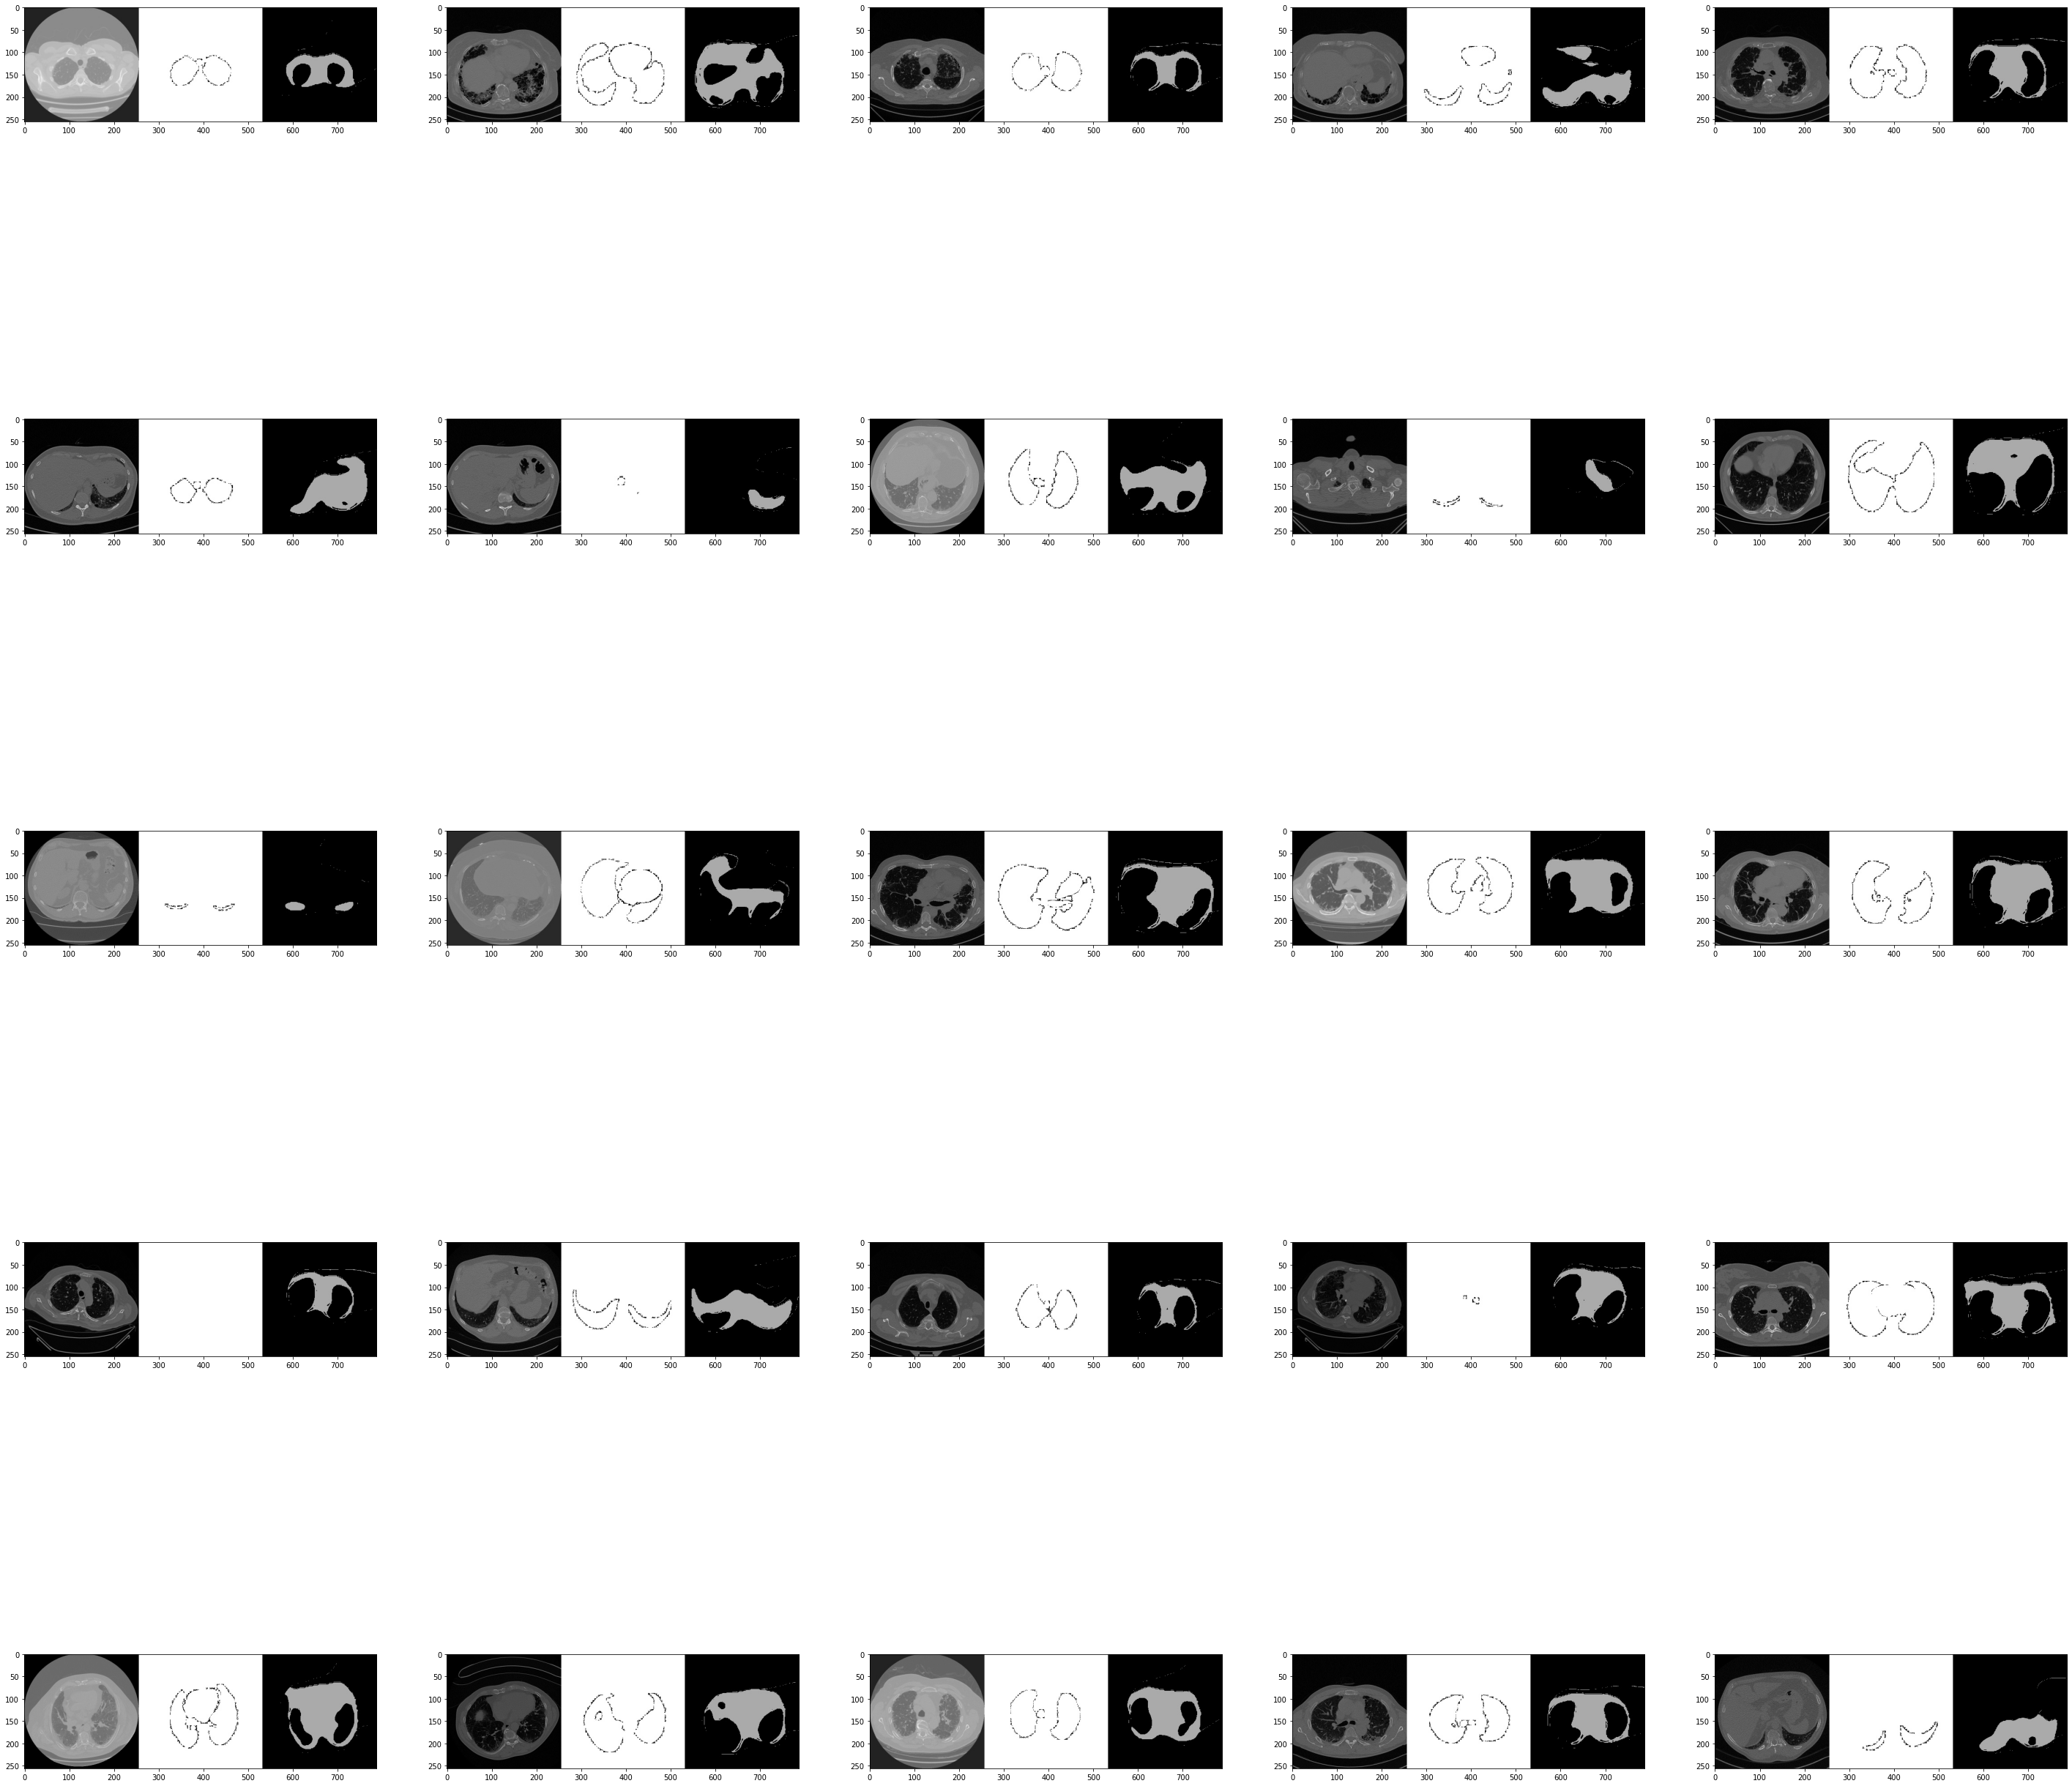

In [43]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(50,50))
for i in range(25):
    plt.subplot(5,5,i+1)
    image = mpimg.imread(test_images[i])
    plt.imshow(image)
plt.show()